In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
import sys

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import cartopy.crs as ccrs
import matplotlib.patches as patches

from CAP.caliop import CALIOP
from CAP.collocation import CALIOP_SUBSET_EXTENT
from CAP.visualization import plot_caliop_curtain
from CAP.vertical_feature_mask import FEATURE_SUBTYPE

plt.rc("font", family="serif")

In [23]:
# Change these to point to the correct location!
L1_path = "/net/d15/data/vmeijer/CALIOP_L1/CAL_LID_L1-Standard-V4-10.2018-02-04T18-55-11ZD_Subset.hdf"
L2_path = ("/net/d13/data/vmeijer/data/CALIPSO/CALIOP_L2/"
            "CAL_LID_L2_05kmCLay-Standard-V4-20.2018-02-04T18-55-11ZD_Subset.hdf")

ca_L1 = CALIOP(L1_path)
ca_L2 = CALIOP(L2_path)

In [19]:
# Get backscatter data that is not yet interpolated
b532_coarse = ca_L1.get("Total_Attenuated_Backscatter_532")

# Load backscatter colormap
cmap, norm, ticks = ca_L1.get_backscatter_cmap()
norm.extend = "both"

In [6]:
# Read metadata, which includes the altitudes corresponding to the different columns in the CALIOP L1 datasets
ca_L1.read_meta_data()

# Altitudes with change in vertical resolution (see figure on resolutions in my thesis)
alts_res_change = [30.1, 20.1, 8.5]

# Now find the indices within the CALIOP LIDAR altitude array corresponding to these
indices = []
for alt in alts_res_change:
    indices.append(np.argmin(np.abs(np.array(ca_L1.Lidar_Data_Altitudes) - alt)))
    

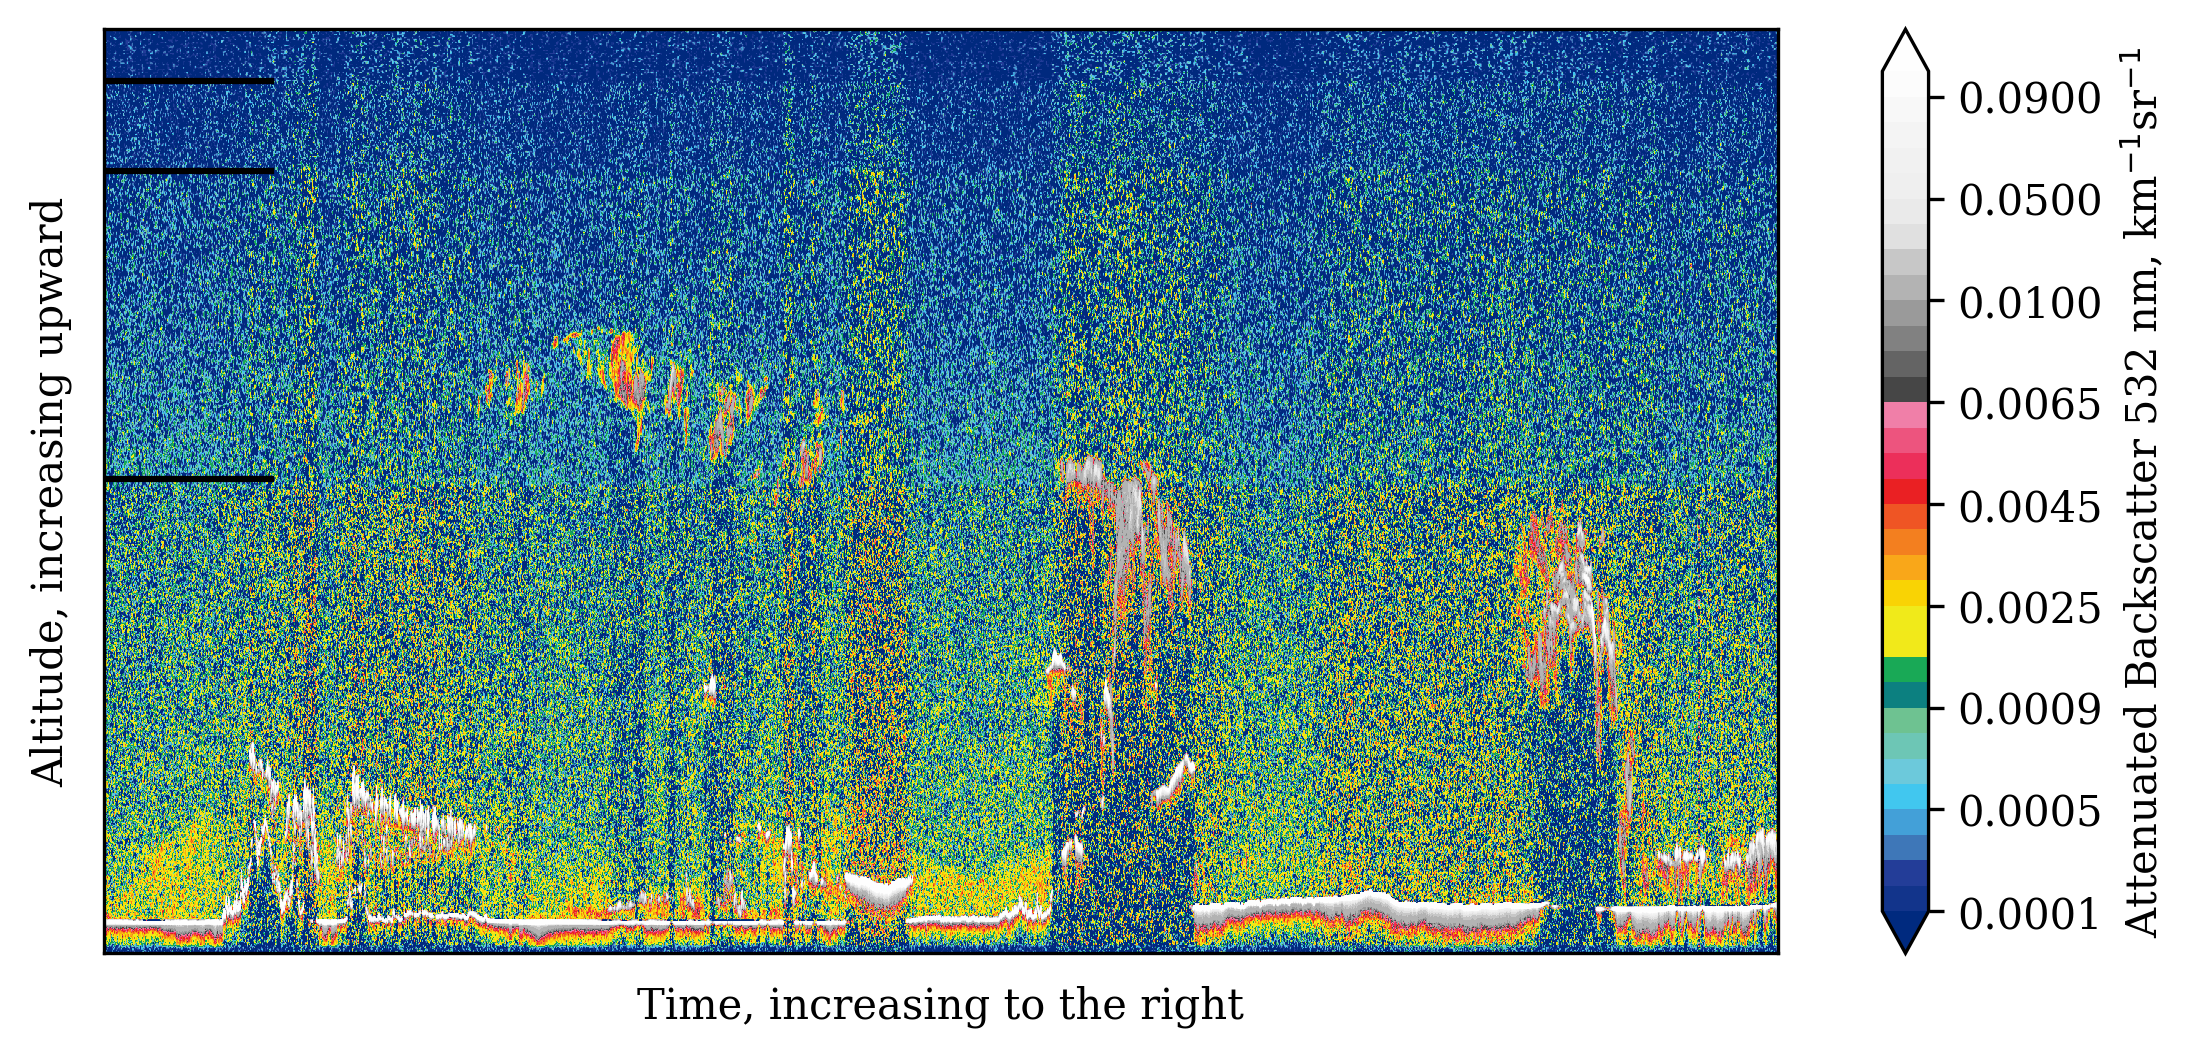

In [7]:
fig, ax = plt.subplots(dpi=300, figsize=(9, 4))
cf = ax.imshow(b532_coarse.T, cmap=cmap, norm=norm)
ax.set_aspect("auto")
cb = plt.colorbar(cf, ax=ax, label="Attenuated Backscatter 532 nm, km${}^{-1}$sr${}^{-1}$")

ax.set_xticks([])
ax.set_yticks([])
ax.set(xlabel="Time, increasing to the right", ylabel="Altitude, increasing upward")

# Add ticks indicating vertical resolution change altitudes
for idx in indices:
    ax.axhline(idx, xmin=0, xmax=0.1, c='k')

Plot aspect ratio slightly different than the one currently in my thesis. That is mostly to accomodate the longer colorbar label, which now also includes the backscatter units. Same holds for the following two plots.

### With vertical interpolation

In [8]:
# Get backscatter data that is vertically interpolated
b532_itp = ca_L1.get_interpolated_subset("Total_Attenuated_Backscatter_532", CALIOP_SUBSET_EXTENT)

# Get profile IDs to use as x-coordinate
profile_ids = ca_L1.get("Profile_ID")

[Text(0.5, 0, 'Profile ID (increasing with time)'),
 Text(0, 0.5, 'Altitude, km')]

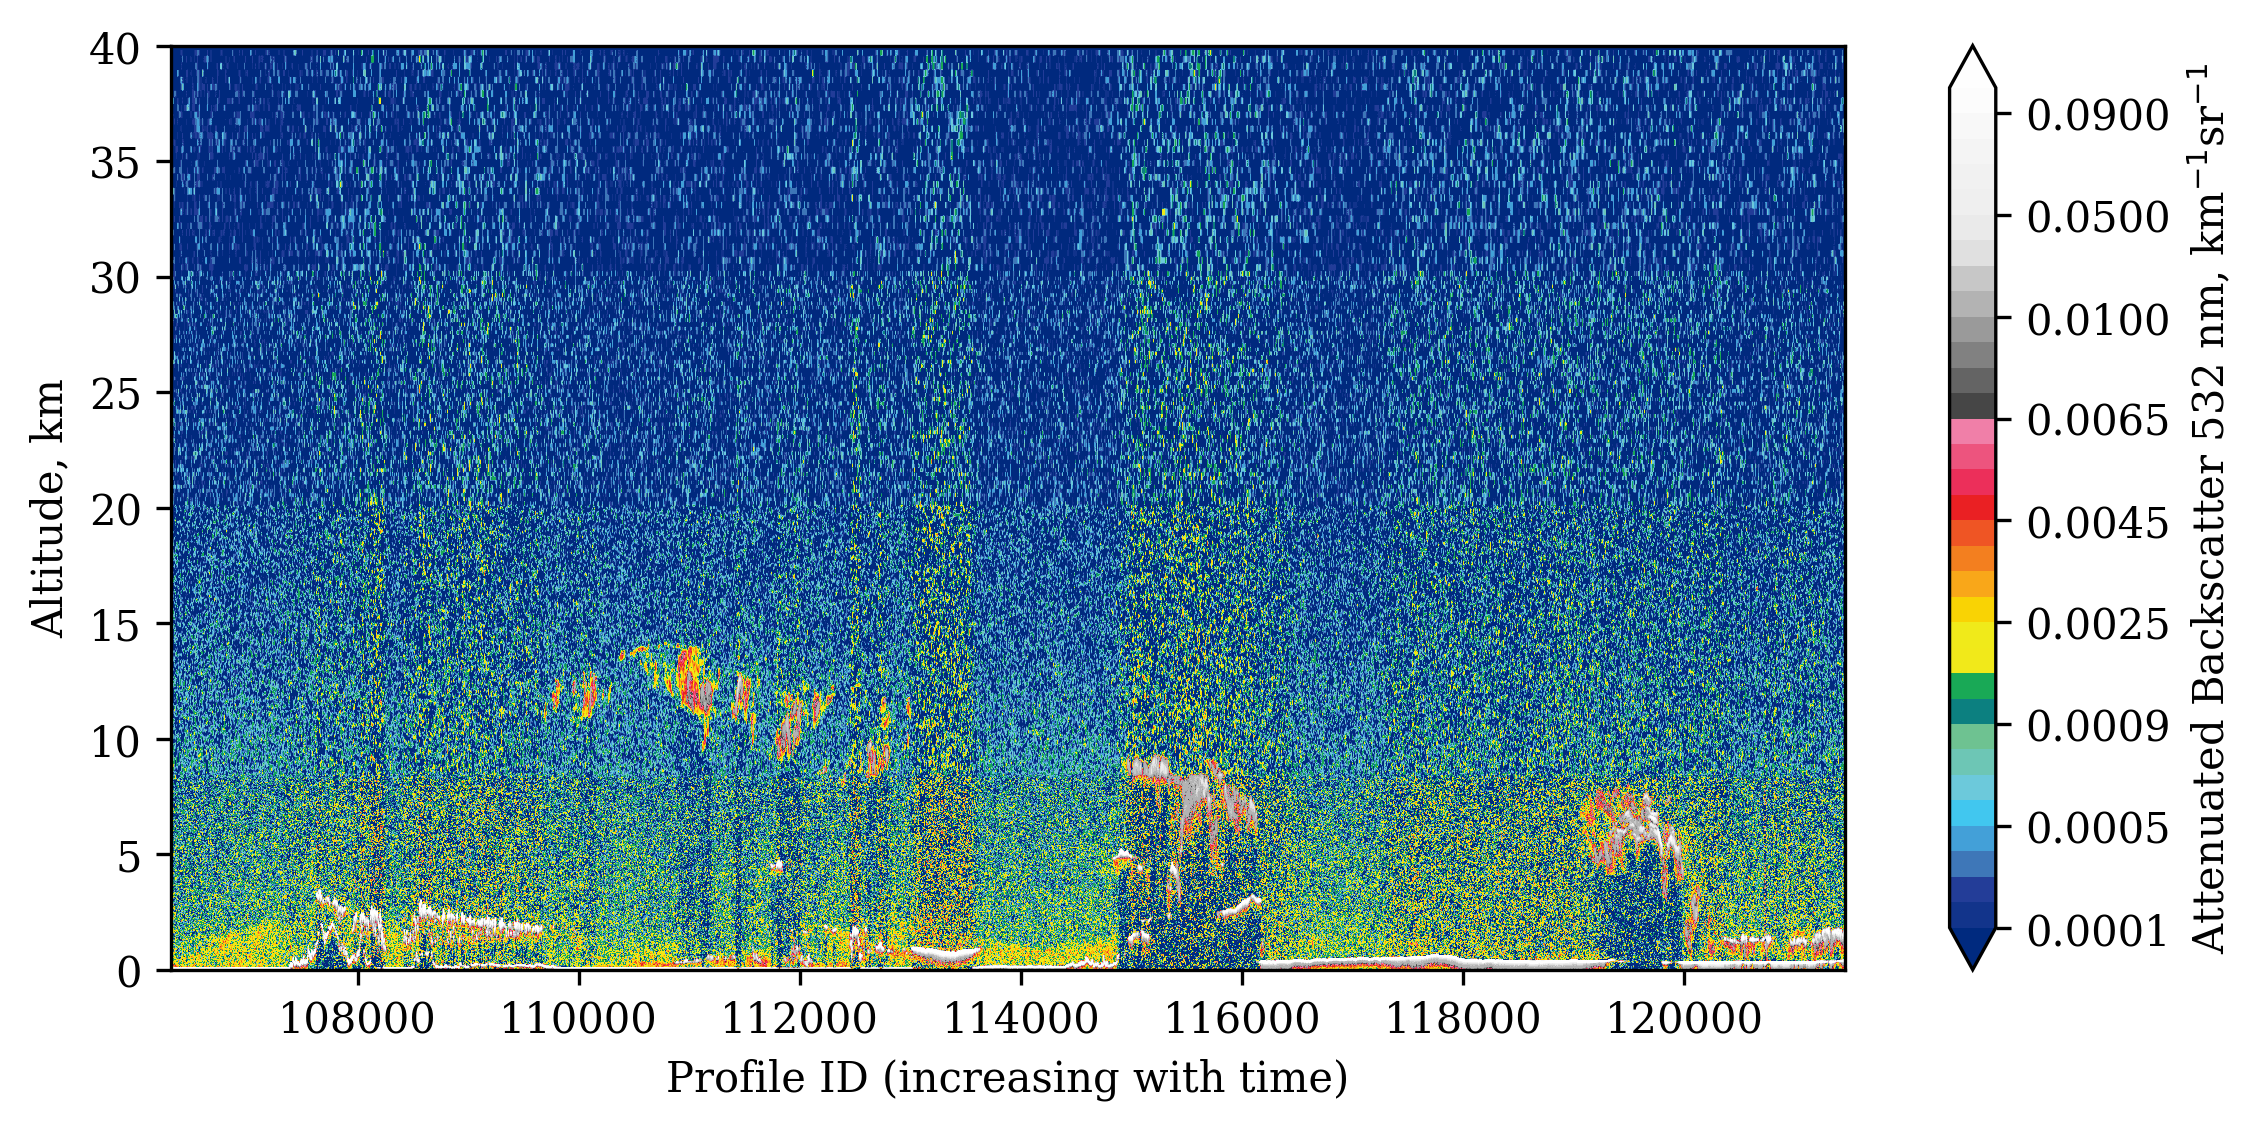

In [9]:
fig, ax = plt.subplots(dpi=300, figsize=(9, 4))
cf = ax.imshow(b532_itp.T, cmap=cmap, norm=norm, extent=(np.min(profile_ids), np.max(profile_ids), 0, 40.0))
ax.set_aspect("auto")
cb = plt.colorbar(cf, ax=ax, label="Attenuated Backscatter 532 nm, km${}^{-1}$sr${}^{-1}$")
ax.set(xlabel="Profile ID (increasing with time)", ylabel="Altitude, km")

### With L2 data

In [22]:
# Use this to map the L2 feature classification flag data to different colors
color_mapper = {"transition stratocumulus" : "m",
                "low, broken cumulus" : "r",
                "cirrus (transparent)" : "brown",
                "deep convective (opaque)" : "b",
                "altocumulus (transparent)" : "m",
                'altostratus (opaque)' : "r",
               'low overcast, opaque' : "m",
               'low overcast, transparent' : 'r'}


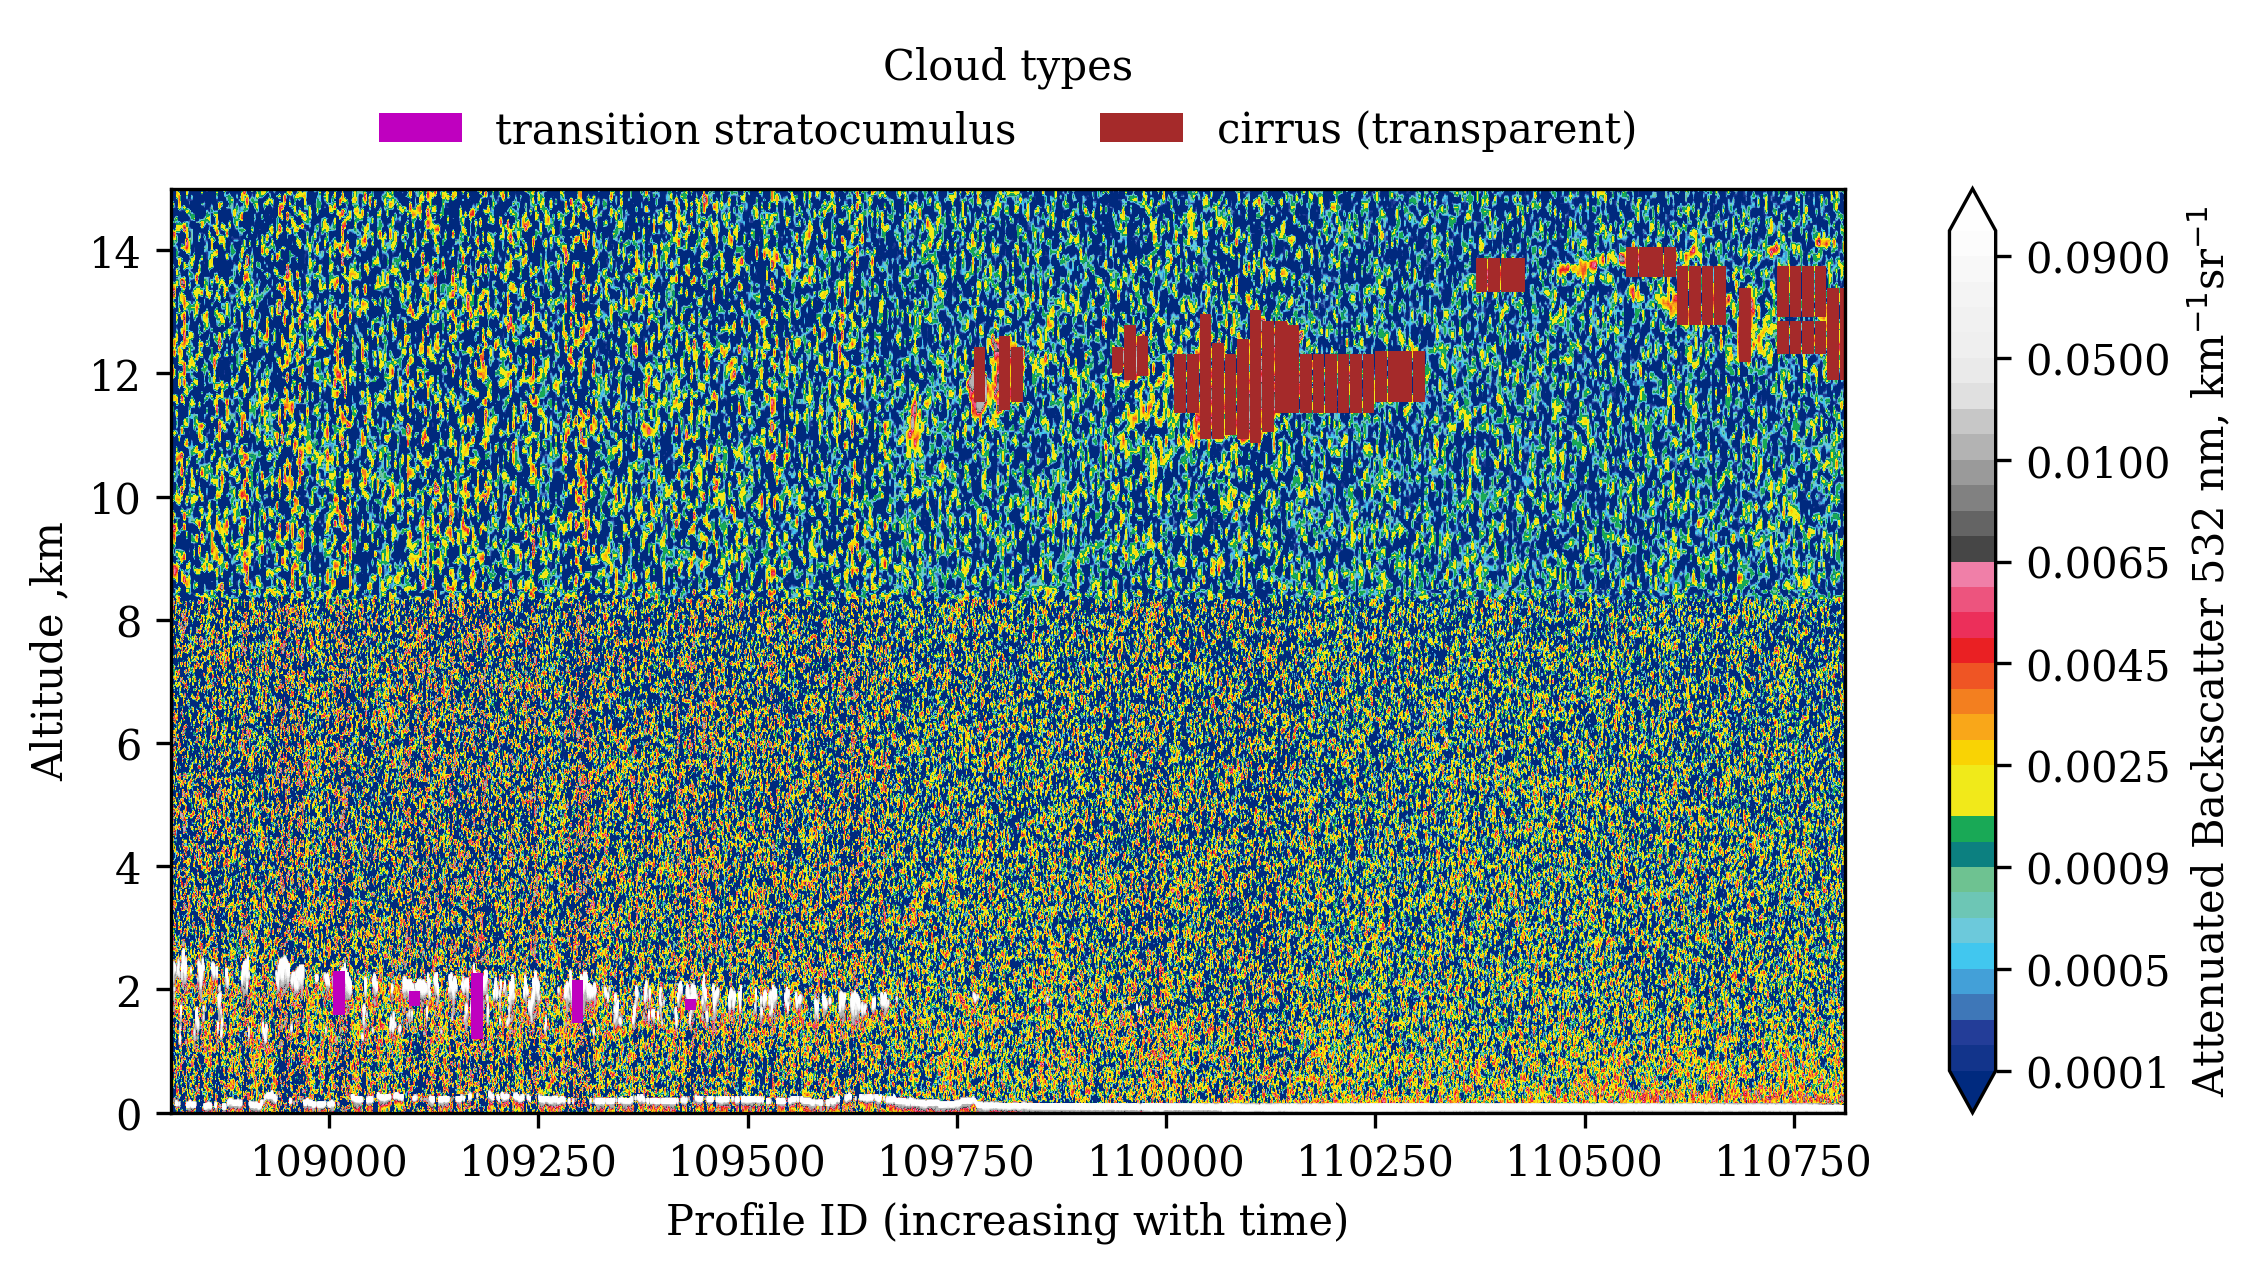

In [18]:
fig, ax = plt.subplots(dpi=300, figsize=(9, 4))

x_coord = profile_ids
data = ca_L1.get_interpolated_subset("Total_Attenuated_Backscatter_532", CALIOP_SUBSET_EXTENT, ve1=0, ve2=15.0)

im = ax.imshow(data.T[:,2500:4500], extent=(x_coord[2500,0], x_coord[4500][0], 0., 15.), cmap=cmap, norm=norm)
ax.set_aspect("auto")

plt.colorbar(im, cmap=cmap, norm=norm, label="Attenuated Backscatter 532 nm, km${}^{-1}$sr${}^{-1}$")


L2_data = ca_L2.get("Feature_Classification_Flags")

top_alts = ca_L2.get("Layer_Top_Altitude")
bot_alts = ca_L2.get("Layer_Base_Altitude")

x_L2 = ca_L2.get("Profile_ID")


for (i,j) in zip(*np.where(L2_data != 1)):
    
    # Get the bounding box of the feature
    left = x_L2[i,0]
    right = x_L2[i,1]
    top = top_alts[i,j]
    bot = bot_alts[i,j]
    
    # Interpret feature classification flag
    # Convert to bitstring
    bitstring = bin(int(L2_data[i,j]))[2:]
    
    # Then take bits 10-12 (see vertical_feature_mask.py for more information)
    feature_subtype_bits = bitstring[-12:-9]
    
    # And convert to integer again
    feature_subtype_flag = int('0b' + feature_subtype_bits, 2)
    feature = FEATURE_SUBTYPE[2][feature_subtype_flag]
    c = color_mapper[feature]
    
    # Add rectangle for the L2 feature
    ax.add_patch(patches.Rectangle((left, bot), width=abs(right-left), height=top-bot,
                                  facecolor=c, zorder=2))

# Add dummy rectangles for the legend
for k,v in color_mapper.items():
    
    # Based on a priori knowledge that the only L2 features found in this subset
    # of the CALIOP curtain are the transition stratocumulus and transparent cirrus
    # if you use this plotting routine for a different CALIOP curtain
    # you should change this.
    if k in ["transition stratocumulus", "cirrus (transparent)"]:
        ax.add_patch(patches.Rectangle((0,0),
                                       width=0,
                                       height=0,
                                       facecolor=v,
                                       label=k))

ax.set(xlabel="Profile ID (increasing with time)", 
       ylabel="Altitude ,km")


ax.legend(loc="lower center", bbox_to_anchor=(0.5,1), frameon=False, ncol=2, title="Cloud types")
